<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/XGBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [3]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [4]:
def model_performance(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape = MAPE(y_true, y_pred)
  return f"RMSE: {rmse} \n MAPE: {mape}"

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', index_col=['date'], parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', index_col=['date'], parse_dates = ['date'])

In [7]:
# Drop pre covid rows
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [8]:
# Drop useless and problematic cols
train = train.drop(columns = ['location_key_x', 'Unnamed: 0.1', 'Unnamed: 0', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'day_name'])
test = test.drop(columns = ['location_key_x', 'Unnamed: 0.1', 'Unnamed: 0', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'day_name'])

In [9]:
# Substitute large numbers for rows before vaccination became available
train_no_vaccination = train['new_persons_fully_vaccinated'] == 0
test_no_vaccination = test['new_persons_fully_vaccinated'] == 0
train.loc[train_no_vaccination, 'new_persons_fully_vaccinated'] = 99999
test.loc[test_no_vaccination, 'new_persons_fully_vaccinated'] = 99999

In [10]:
# one-hot encoding

# country_code label encoding
country_train = pd.get_dummies(train['country_code'],drop_first=True)
country_test = pd.get_dummies(test['country_code'],drop_first=True)

# season
season_train = pd.get_dummies(train['season'],drop_first=True)
season_test = pd.get_dummies(test['season'],drop_first=True)


train = pd.concat([train, country_train, season_train], axis = 1).drop(columns = ['country_code', 'season'])
test = pd.concat([test, country_test, season_test], axis = 1).drop(columns = ['country_code', 'season'])

In [11]:
x_train = train.drop(columns = 'new_confirmed')
y_train = train.new_confirmed
x_test = test.drop(columns = 'new_confirmed')
y_test = test.new_confirmed

>50 730.547 (79.230)
>500 723.230 (81.112)
>1000 723.159 (81.102)
>3000 723.150 (81.142)
>5000 723.151 (81.142)


Text(0.5, 0, 'Number of trees')

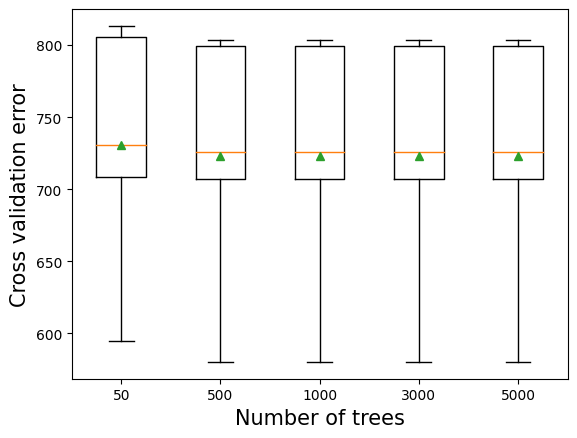

In [52]:
# Number of trees vs cross validation error
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [50, 500, 1000, 3000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 1085.595 (156.116)
>2 892.085 (156.902)
>3 794.065 (142.512)
>4 778.650 (165.840)
>5 758.492 (150.710)
>6 745.983 (170.220)
>7 765.242 (171.891)
>8 770.528 (165.343)
>9 747.320 (173.401)
>10 761.291 (174.256)


Text(0.5, 0, 'Depth of each tree')

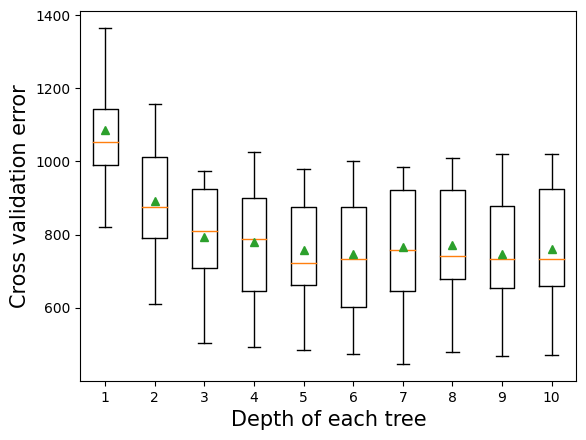

In [53]:
# Depth of tree vs cross validation error
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,11):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0100 1264.1 (139.4)
>0.0500 764.5 (165.1)
>0.1000 746.7 (176.1)
>0.2000 722.4 (165.4)
>0.3000 746.0 (170.2)
>0.4000 758.0 (168.4)
>0.5000 803.4 (160.9)
>0.6000 803.7 (176.0)
>0.8000 907.1 (194.8)
>1.0000 950.0 (197.4)


Text(0.5, 0, 'Learning rate')

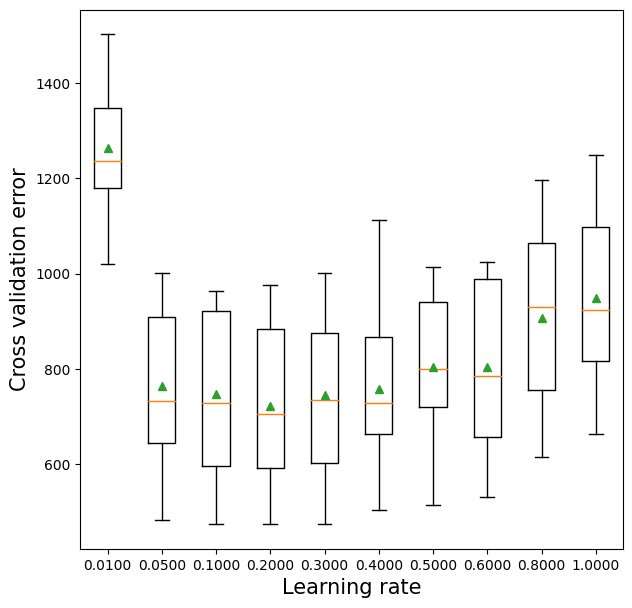

In [54]:
# Learning rate vs cross validation error

def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0000 781.6 (194.0)
>0.5000 743.9 (167.5)
>1.0000 746.0 (170.2)
>1.5000 747.8 (173.4)
>2.0000 735.4 (161.6)
>10.0000 759.9 (167.1)
>100.0000 786.5 (166.7)


Text(0.5, 0, 'reg_lambda')

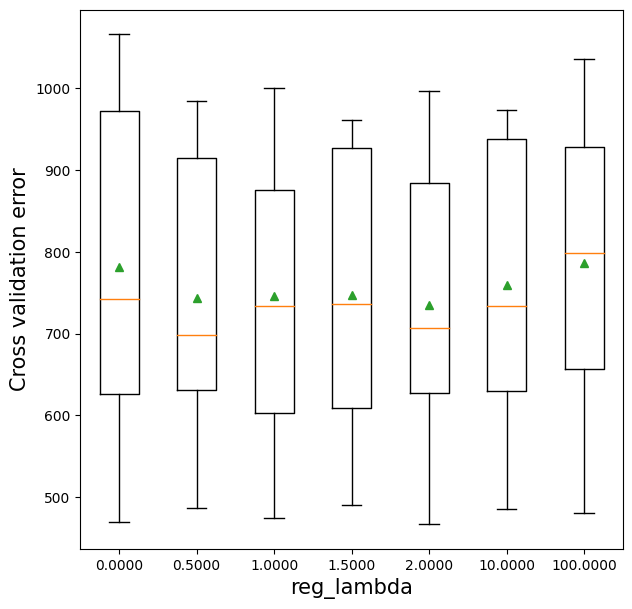

In [12]:
# Regularization (reg_lambda) vs cross validation error
def get_models():
    models = dict()
    # explore 'reg_lambda' from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

>0.0000 746.0 (170.2)
>10.0000 746.0 (170.2)
>100.0000 746.0 (170.2)
>1000.0000 745.0 (168.3)
>10000.0000 747.5 (168.7)
>100000.0000 751.0 (173.7)
>1000000.0000 754.0 (168.2)
>10000000.0000 770.3 (161.5)
>100000000.0000 809.3 (145.9)
>1000000000.0000 934.4 (128.8)


Text(0.5, 0, 'gamma')

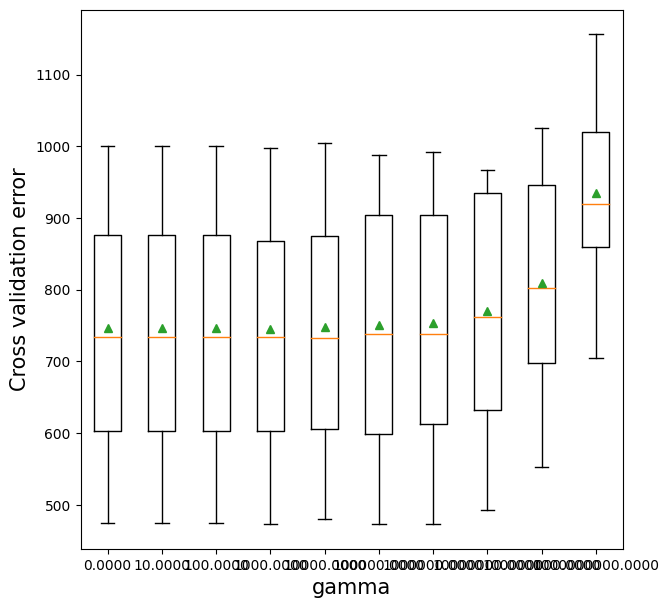

In [13]:
# Regularization (gamma) vs cross validation error
def get_models():
    models = dict()
    # explore gamma from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

In [13]:
def visual_performance(max_depth, learning_rate, reg_lambda, n_estimators, gamma, subsample):
  model = xgb.XGBRegressor(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_lambda=reg_lambda, gamma=gamma, n_jobs=-1, random_state=45)
  model.fit(x_train, y_train)

  train_pred=pd.DataFrame(model.predict(x_train), columns=['yhat'], index=x_train.index)
  pd.concat([y_train,train_pred['yhat']], axis=1).plot(figsize=(15,5))
  plt.legend(['train', 'train_pred'])

  test_pred=pd.DataFrame(model.predict(x_test), columns=['yhat'], index=test.index)
  pd.concat([y_test,test_pred['yhat']], axis=1).plot( )
  plt.legend(['test', 'test_pred'])

  # model performance
  train_score = model_performance(y_train, train_pred.yhat)
  test_score = model_performance(y_test, test_pred.yhat)
  return f"train: {train_score}, test: {test_score}"

In [20]:
param_grid = {'max_depth': [5,6,7,8],
              'learning_rate': [0.05,0.1,0.2,0.3],
               'reg_lambda':[0,0.001,0.1,1,10,100],
                'n_estimators':[700,1000,3000,5000],
              'gamma':[0,0.001,0.1,1,10,100],
              'subsample':[0.1,0.25,0.5,1]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),
                             param_distributions = param_grid, n_iter = 30,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)

optimal_params.fit(x_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimal parameter values = {'subsample': 0.25, 'reg_lambda': 0.1, 'n_estimators': 3000, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1}


<ipython-input-3-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
<ipython-input-3-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'train: RMSE: 84.95106903407073 \n MAPE: inf, test: RMSE: 3982.595832230087 \n MAPE: inf'

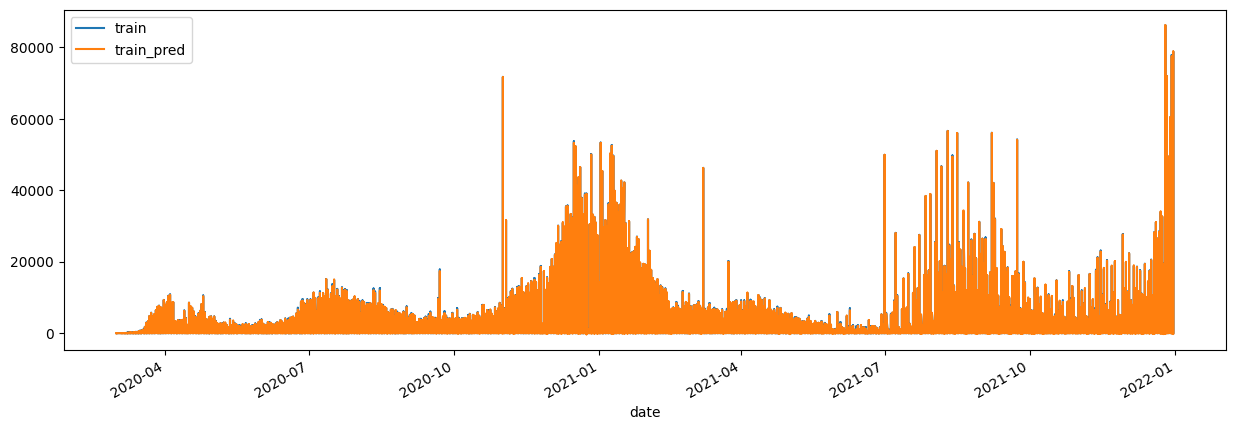

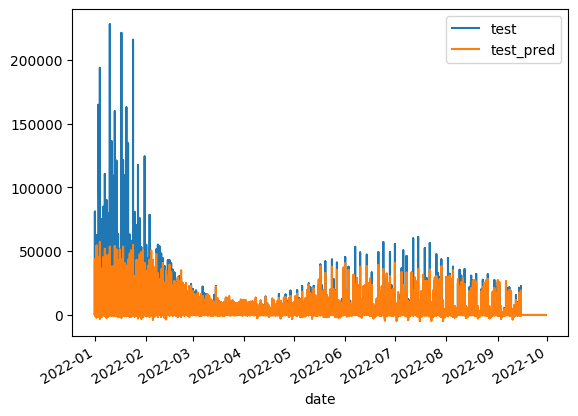

In [14]:
visual_performance(5, 0.05, 0.1, 3000, 0.1, 0.25)

<ipython-input-2-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
<ipython-input-2-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'train: RMSE: 58.46849877838912 \n MAPE: inf, test: RMSE: 3865.7115100842657 \n MAPE: inf'

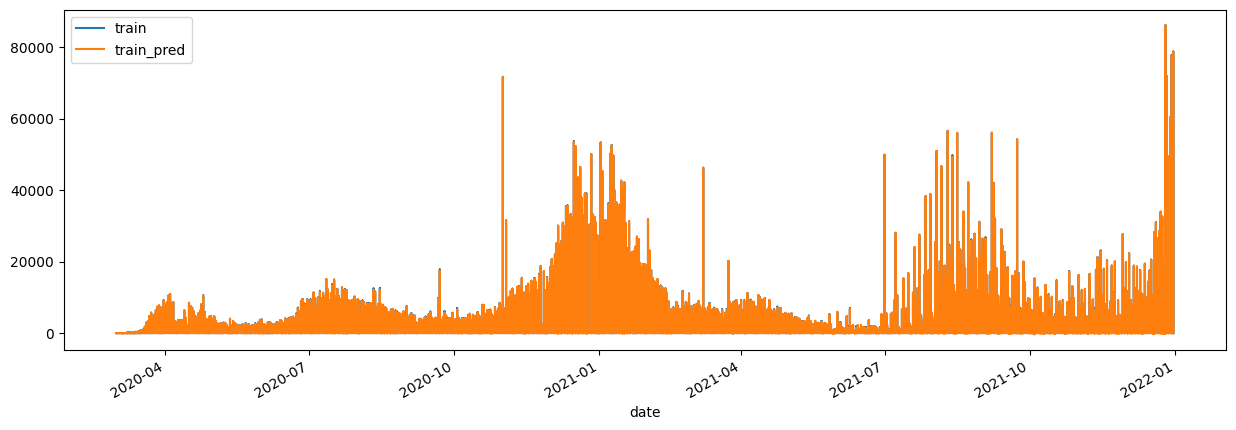

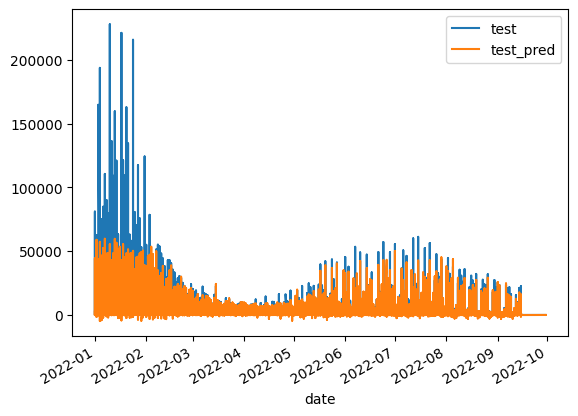

In [17]:
visual_performance(5, 0.2, 2, 4000, 1000, 1)

<ipython-input-2-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
<ipython-input-2-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'train: RMSE: 45.42357824997717 \n MAPE: inf, test: RMSE: 4078.724990293031 \n MAPE: inf'

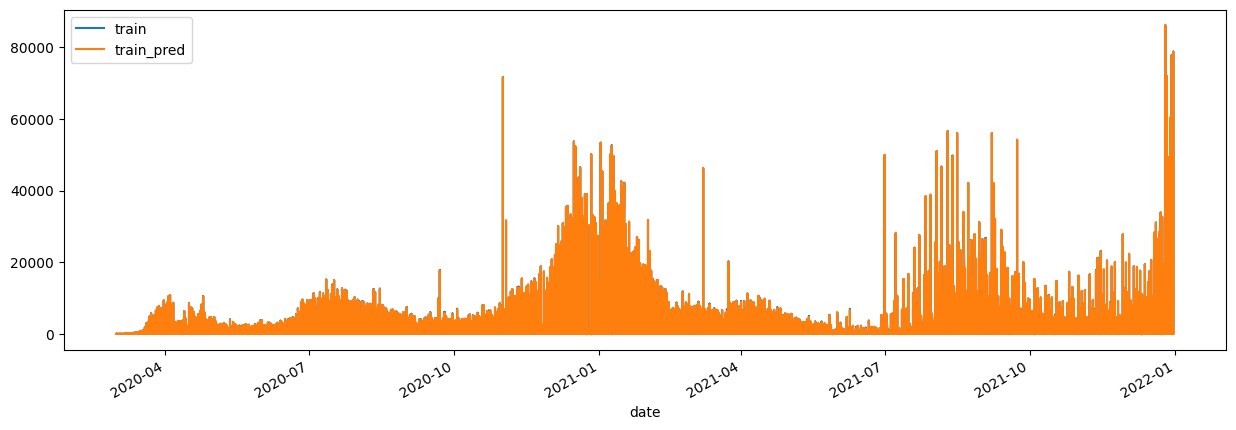

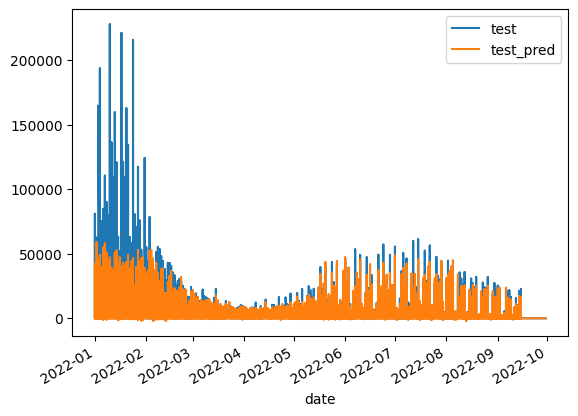

In [19]:
visual_performance(7, 0.2, 3, 3000, 1000, 1)